In [1]:
import operator
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn import feature_selection
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler, RobustScaler, Imputer, LabelEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

from IPython.core.pylabtools import figsize 
%matplotlib inline

In [2]:
RANDOM_STATE = 42
DATA_FOLDER = "../data/"

In [6]:
hum = pd.read_csv(DATA_FOLDER + "humsavar_gt.tab.gz", sep="\t")
hum.rename(columns={"Type of variant HumsaVar": "TYPE"}, inplace=True)
hum["MUTANT"] = hum.MUTANT.str.rstrip()
hum.drop_duplicates(inplace=True)
hum.drop_duplicates(subset="MUTANT", keep=False, inplace=True)
protparam = pd.read_csv(DATA_FOLDER + "protparam_features.tab.gz", sep="\t")
hum = hum.merge(protparam, on="MUTANT", how="left")

In [7]:
hum

,MUTANT,3DID,ACTIVE_SITE,AGGREGABILITY,BFACTOR,CONSERVATION,PDB,SASA,SASA_PERCENTAGE,SWITCHBILITY,VARIATION_ENERGY,TYPE,aromaticity,isoelectric_point,gravy
0,P11362-174-V-A,False,NaN,0.000,32.2800,NaN,False,6.038,0.03,NaN,2.699420,Disease,0.047619,10.037781,-0.309524
1,Q8WZA1-504-V-I,False,NaN,NaN,67.4650,NaN,False,90.814,0.51,0.00000,-0.341963,Polymorphism,0.190476,6.026672,-0.276190
2,P46100-243-C-F,False,BINDING,NaN,0.0000,NaN,False,1.143,0.00,0.06610,26.057600,Disease,0.142857,9.388000,-0.342857
3,P11473-362-T-I,False,NaN,NaN,11.2900,NaN,False,0.214,0.00,0.00000,-0.832075,Polymorphism,0.047619,8.230652,-0.414286
4,Q9NXN4-106-G-S,True,NaN,0.000,37.4300,0.24,False,0.000,0.00,0.04100,2.827400,Polymorphism,0.000000,9.045959,-1.171429
5,P07101-375-F-L,False,NaN,NaN,44.1225,NaN,False,4.589,0.01,0.00000,1.240750,Disease,0.047619,5.210876,0.219048
6,P40692-68-I-N,True,NaN,0.000,44.9725,0.23,False,37.920,0.18,1.53000,2.216710,Disease,0.000000,4.296326,-0.647619
7,O95497-325-A-E,False,NaN,10.032,39.7600,NaN,False,29.466,0.24,0.03170,-0.237174,Polymorphism,0.142857,4.785950,-0.957143
8,P13645-449-Y-C,False,NaN,NaN,200.3725,NaN,True,73.163,0.25,0.78800,1.903220,Disease,0.000000,4.947937,-0.709524
9,P47895-89-R-C,False,NaN,0.000,15.6875,0.31,False,59.656,0.23,0.66700,0.663309,Disease,0.095238,11.524597,-0.423810


In [8]:
model_dict = {
    'lr':{'pipe':('lr', LogisticRegression(random_state=RANDOM_STATE)),
          'params':[{'lr__C' : [.001, .01, .1, 1, 10, 100, 1000], 'lr__class_weight':[None, 'balanced']}],
          'name':'LogisticRegression'
    },
    'rf':{'pipe':('rf', RandomForestClassifier(random_state=RANDOM_STATE)),
          'params':[{'rf__max_depth':[3,5,7], 'rf__n_estimators':[10,50,100], 'rf__max_features':[4,'sqrt',0.2]}],
          'name':'Random Forest'
    },
    'svc':{'pipe':('svc', SVC(kernel='rbf', random_state=RANDOM_STATE)),
           'params':[{'svc__C':[0.001, 0.01, 0.1, 1, 10], 'svc__gamma':[0.001, 0.01, 0.1, 1]}],
           'name': 'Support Vector Classifier'
    }
}

In [9]:
dataset = hum.drop(['3DID', 'PDB'], 1) \
    .replace({"ACTIVE_SITE": {"BINDING": 1, np.nan: 0}}) \
    .set_index("MUTANT")

unclassified_index = dataset[dataset.TYPE == "Unclassified"].index
dataset_disease_index = dataset[dataset.TYPE == "Disease"].index
dataset_poly_index = dataset[dataset.TYPE == "Polymorphism"].index

#### 50-50% en el set de entrenamiento y 60-40% en set de evaluación respetando humsavar

In [10]:
train = pd.concat([
    dataset.loc[dataset_disease_index].sample(n=1500, random_state=RANDOM_STATE),
    dataset.loc[dataset_poly_index].sample(n=1500, random_state=RANDOM_STATE)
])

test = pd.concat([
    dataset.loc[dataset_disease_index.difference(train.index)].sample(n=320, random_state=RANDOM_STATE),
    dataset.loc[dataset_poly_index.difference(train.index)].sample(n=483, random_state=RANDOM_STATE)
])

In [11]:
X_train = train.drop("TYPE", 1)
y_train = train.TYPE
X_test = test.drop("TYPE", 1)
y_test = test.TYPE

In [12]:
y_test.value_counts()

Polymorphism    483
Disease         320
Name: TYPE, dtype: int64

In [13]:
y_train.value_counts()

Disease         1500
Polymorphism    1500
Name: TYPE, dtype: int64

#### Random Forest

In [14]:
algorithm = 'rf'
model = Pipeline([('imputer', Imputer(missing_values="NaN", strategy="median")), 
                  model_dict[algorithm]['pipe']])
param_list = [model_dict[algorithm]['params']][0]
gs = GridSearchCV(model, param_list, cv=3, n_jobs=2, scoring='roc_auc', verbose=1, refit=True)
le = LabelEncoder().fit(y_train)

In [15]:
gs.fit(X_train, le.transform(y_train))

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=2)]: Done  81 out of  81 | elapsed:    8.4s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(steps=[('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_spl...timators=10, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=2,
       param_grid=[{'rf__max_depth': [3, 5, 7], 'rf__n_estimators': [10, 50, 100], 'rf__max_features': [4, 'sqrt', 0.2]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=1)

In [16]:
gs.best_score_

0.73909933333333322

In [13]:
gs.best_score_

0.73465933333333333

In [17]:
rf = gs.best_estimator_

In [18]:
y_pred = rf.predict(X_test)

In [19]:
roc_auc_score(le.transform(y_test), y_pred)

0.66853002070393375

In [16]:
roc_auc_score(le.transform(y_test), y_pred)

0.67447070361325323

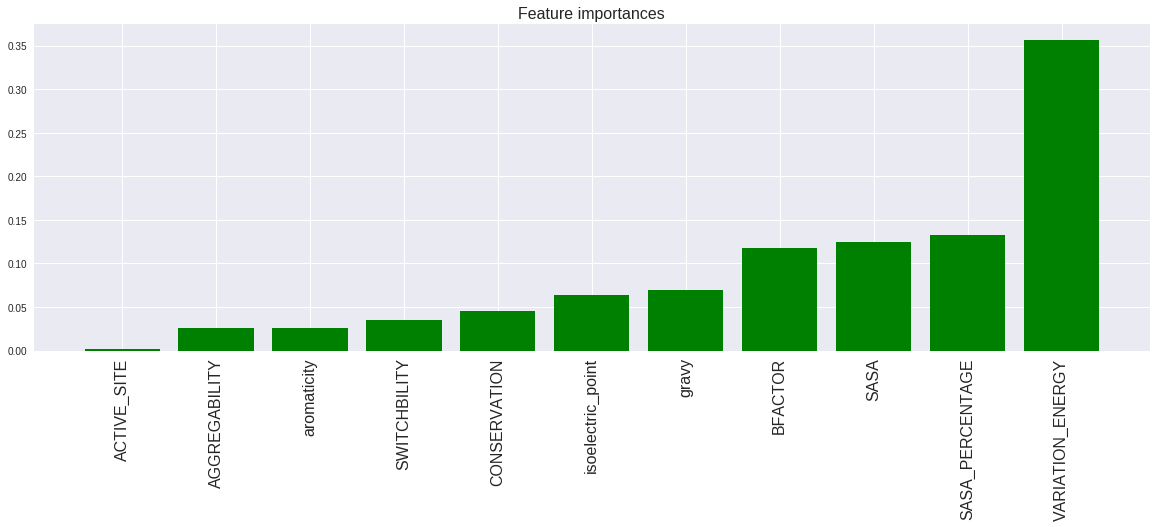

In [20]:
importances = [(X_train.columns[e], x) for e, x in enumerate(rf.steps[1][1].feature_importances_)]
importances.sort(key=operator.itemgetter(1))
figsize(20,6)
plt.title("Feature importances", fontsize=16)
plt.bar(np.arange(len(importances)), [y for x, y in importances], color="g", align="center")
plt.xticks(range(len(importances)), [x for x, y in importances], rotation='vertical', fontsize=16)
# plt.xlim([0, range(len(importances))])
plt.show()

#### Y los unclassified?

In [80]:
pd.Series(le.inverse_transform(rf.predict(dataset.loc[unclassified_index].drop("TYPE", 1)))).value_counts()

Polymorphism    338
Disease         269
dtype: int64

#### Support Vector Classifier

In [21]:
algorithm = 'svc'
model = Pipeline([('imputer', Imputer(missing_values="NaN", strategy="median")), 
                  ('scale', RobustScaler()), 
                  model_dict[algorithm]['pipe']])
param_list = [model_dict[algorithm]['params']][0]
gs = GridSearchCV(model, param_list, cv=3, n_jobs=2, scoring='roc_auc', verbose=1, refit=True)
le = LabelEncoder().fit(y_train)

In [22]:
gs.fit(X_train, le.transform(y_train))

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   11.0s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:   15.0s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(steps=[('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('scale', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('svc', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params={}, iid=True, n_jobs=2,
       param_grid=[{'svc__C': [0.001, 0.01, 0.1, 1, 10], 'svc__gamma': [0.001, 0.01, 0.1, 1]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=1)

In [23]:
gs.best_score_

0.71208399999999983

In [103]:
gs.best_score_

0.6982693333333333

In [24]:
svc = gs.best_estimator_

In [25]:
y_pred = svc.predict(X_test)

In [28]:
roc_auc_score(le.transform(y_test), y_pred)

0.64870600414078672

In [106]:
roc_auc_score(le.transform(y_test), y_pred)

0.67905697748206828